##Hypothesis:
When news media reports more violence, people are more likely to protest — especially if that violent coverage continues over time. But if the media uses very negative or aggressive language (tone), it might also make people feel overwhelmed or discouraged.

We're going to test this by building a model that predicts how many protests happen each year based on:

How much media violence was reported this year and last year

How negative the media’s tone was

How many protests happened last year

##Goal of This Model

Try to predict how many protests happen in a year using what happened in the media the year before.

If protests increase when media violence increases, it means people may be mobilizing and reacting (not tuning out or becoming numb). If protests decrease, that might suggest desensitization — people caring less even when violence rises.

In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
# Prepare the yearly dataset
# We'll group the data by year and calculate:
# - how many protests happened
# - how much media violence was reported
# - what the media tone was like
merged_df = pd.read_csv("../2_data_preparation/merged_df.csv")
yearly_df = (
    merged_df.groupby("year")
    .agg(
        {
            "protest": "count",  # number of protest events
            "SumEvents": "mean",  # average media violence
            "GoldsteinScale": "mean",  # average media tone
        }
    )
    .reset_index()
    .rename(columns={"protest": "protest_volume"})
)

In [6]:
# Add "lagged" features (last year's numbers)
# These help us test if last year's violence affects this year's protests

yearly_df["SumEvents_lag1"] = yearly_df["SumEvents"].shift(1)
yearly_df["protest_volume_lag1"] = yearly_df["protest_volume"].shift(1)

# Drop the first year (it will have missing values because of the shift)
yearly_df.dropna(inplace=True)

In [7]:
# Set up the regression model
# This model will try to explain: "Why did we get this many protests this year?"

X = yearly_df[["SumEvents_lag1", "GoldsteinScale", "protest_volume_lag1"]]
y = yearly_df["protest_volume"]

# Add a constant column (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Show results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         protest_volume   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     38.18
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           1.13e-09
Time:                        00:40:21   Log-Likelihood:                -245.79
No. Observations:                  30   AIC:                             499.6
Df Residuals:                      26   BIC:                             505.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.328e+05   7

Here’s how to understand the key parts of the output:

R-squared = 0.815	The model explains 81.5% of protest variation. That’s very strong!
SumEvents_lag1	The most important variable: last year’s media violence
Its p-value = 0.015	That’s below 0.05 → statistically significant 
Coefficient = 2.75	Every unit increase in media violence last year = about 2.75 more protests this year

Other variables:
GoldsteinScale (tone): may reduce protests slightly, but wasn’t strongly significant.

protest_volume_lag1: last year’s protests didn’t help predict this year’s — people aren’t just protesting out of habit.



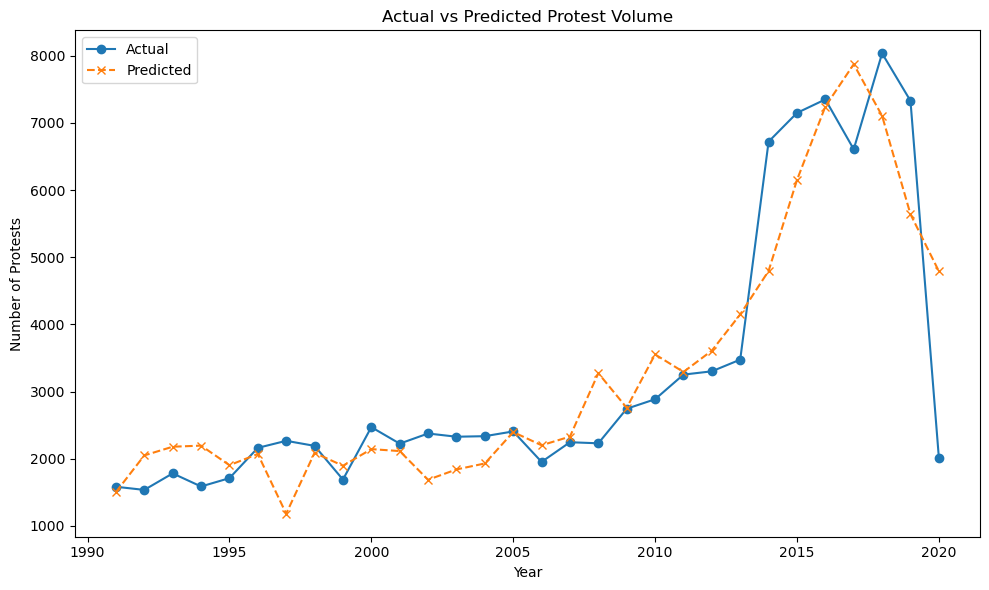

In [8]:
# Visualize the results — Actual vs Predicted protest volume

# Add predictions to the dataframe
yearly_df["predicted"] = model.predict(X)

# Plot actual vs predicted protests
plt.figure(figsize=(10, 6))
plt.plot(yearly_df["year"], yearly_df["protest_volume"], label="Actual", marker="o")
plt.plot(
    yearly_df["year"],
    yearly_df["predicted"],
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.xlabel("Year")
plt.ylabel("Number of Protests")
plt.title("Actual vs Predicted Protest Volume")
plt.legend()
plt.tight_layout()
plt.show()

In 2019, the model predicted fewer protests than actually happened. This shows that while media violence helps predict protest activity in general, it missed other powerful forces in 2019 like major events, political shifts, or social media campaigns that inspired people to act. Our model based on media violence was helpful, but it couldn’t see those things.That reminds us that media coverage alone doesn’t control civic behavior — it’s part of the story, not the whole thing.

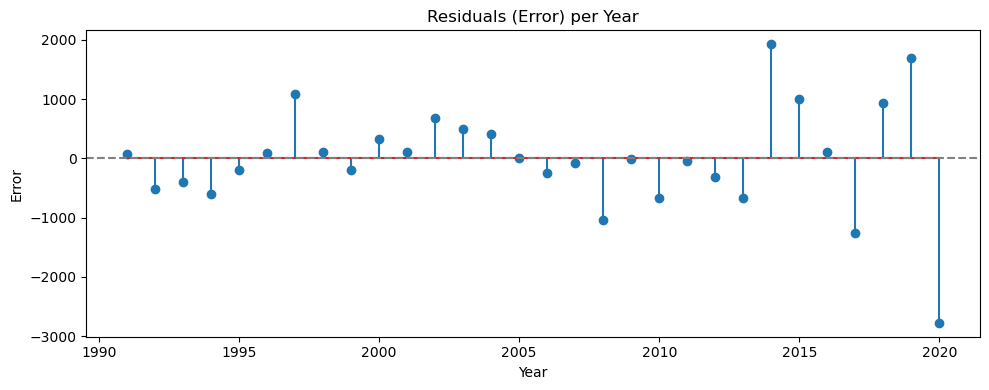

In [9]:
#  Plot residuals (the difference between prediction and actual)
plt.figure(figsize=(10, 4))
plt.stem(yearly_df["year"], yearly_df["protest_volume"] - yearly_df["predicted"])
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals (Error) per Year")
plt.xlabel("Year")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

This chart shows how far off our model was each year.

When a dot is above the line, the model predicted too few protests.

When it's below the line, it predicted too many.

Most years are close to the line, which means the model did a pretty good job.
But in 2019, the model underestimated protests — suggesting something happened that the model couldn’t account for.
And in 2020, the prediction looks way off, but that’s just because our dataset only includes protests through March, not the full year.

In years where actual protest activity was higher than predicted, it could mean people were mobilized by factors outside of media violence — like social justice movements, economic struggles, or viral online campaigns.

This might reflect increased empathy, urgency, or awareness — showing that people aren’t passive. Sometimes, they act even more than expected.
It reminds us that while models are helpful, real-world behavior is driven by more than just data — and that’s an important insight.

In [10]:
# Check for multicollinearity (are any variables too similar?)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

               feature            VIF
0                const  202651.171498
1       SumEvents_lag1      15.525811
2       GoldsteinScale       2.328991
3  protest_volume_lag1      12.397284


 Hypothesis 1 – Conclusion
We built a model to test whether media violence can predict protest activity. The results show that when there's more violence in the media one year, protest activity tends to rise the following year. This suggests that people are not becoming emotionally numb, instead, they're reacting and mobilizing.

This relationship was statistically significant, and the model explained about 81% of the variation in protest volume. Media tone (how negative or positive the coverage was) had a smaller effect, and past protest levels didn’t contribute much.

In short: people seem to be responding to real-world conditions, not just repeating past behaviors. They're not passive — they act when exposed to violence in the world around them.

